# 二维卷积实验

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

import random
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 设置中文支持
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

## 数据准备

In [2]:
class FoggyDataset(Dataset):
    def __init__(self, foggy_dir, defog_dir, transform=None):
        self.foggy_dir = foggy_dir
        self.defog_dir = defog_dir
        self.transform = transform
        self.foggy_images = os.listdir(foggy_dir)
        self.defog_images = os.listdir(defog_dir)

    def __len__(self):
        return len(self.foggy_images)

    def __getitem__(self, idx):
        foggy_img_name = os.path.join(self.foggy_dir, self.foggy_images[idx])
        defog_img_name = os.path.join(self.defog_dir, self.defog_images[idx])
        foggy_img = Image.open(foggy_img_name).convert('RGB')
        defog_img = Image.open(defog_img_name).convert('RGB')

        if self.transform:
            foggy_img = self.transform(foggy_img)
            defog_img = self.transform(defog_img)

        return foggy_img, defog_img


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 有雾图片文件夹路径
foggy_dir = r'Datasets\RemoveFogDatasets\FogPictures'
# 去雾图片文件夹路径
defog_dir = r'Datasets\RemoveFogDatasets\NoFogPictures'

dataset = FoggyDataset(foggy_dir, defog_dir, transform)

# 计算用于划分训练集和测试集的样本数量
total_samples = len(dataset)
train_samples = int(0.8 * total_samples)
test_samples = total_samples - train_samples

# 划分训练集和测试集
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_samples, test_samples])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练集大小：", len(train_dataset))
print("测试机大小：", len(test_dataset))

训练集大小： 416
测试机大小： 104


torch.Size([32, 3, 128, 128]) torch.Size([32, 3, 128, 128])


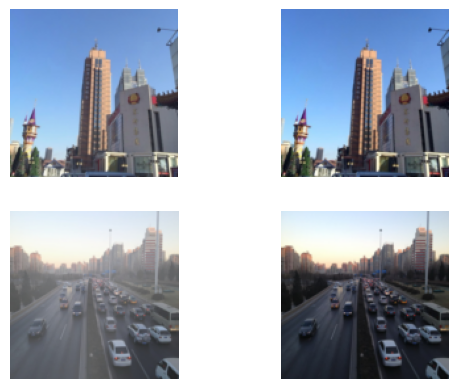

In [3]:
# 查看加载器中数据的shape
for X, y in train_loader:
    print(X.shape, y.shape)
    break

# 抽样显示训练集中图片
fig, axes = plt.subplots(2, 2)
for i in range(2):
    axes[i][0].imshow(transforms.ToPILImage()(train_dataset[i+19][0]))
    axes[i][0].axis('off')
    axes[i][1].imshow(transforms.ToPILImage()(train_dataset[i+19][1]))
    axes[i][1].axis('off')
plt.show()

## 函数准备

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
# 定义绘图函数

# 绘制训练损失和测试损失的函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(dpi=100)
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label="train", color="red", linewidth=1)
    plt.plot(x, test_loss, label="test", color="blue", linewidth=1)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 绘制损失值对比函数
def loss_comparison(losses, labels, title):
    plt.figure(dpi=100)
    x = np.arange(len(losses[0]))
    for idx, loss in enumerate(losses):
        plt.plot(x, loss, label=labels[idx], linewidth=1)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 定义训练时间对比图
def train_time_comparison(times, labels, title):
    plt.figure(dpi=100)
    bars = plt.bar(labels, times, color=['blue', 'green', 'red'])

    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')

    # 在每个柱子上方显示时间数据
    for bar, time in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(time), ha='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()


In [6]:
# 训练函数
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    train_batch_num = len(data_loader)
    total_loss = 0

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data, target = data.to(device).float(), target.to(device).float()

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        output = model(data)
        # 计算损失
        loss = criterion(output, target)
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
        
        # 累加loss
        total_loss += loss.item()

    loss = total_loss / train_batch_num
    return loss

# 测试函数
def test_model(model, data_loader, criterion, device):
    model.eval()
    test_batch_num = len(data_loader)
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device).float(), target.to(device).float()
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
    loss = total_loss / test_batch_num
    return loss

# 模型训练过程函数
def train(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    # 训练模型并验证
    train_losses = []
    test_losses = []
    start = time.time()

    # 进行训练
    for epoch in range(epochs):
        # 在训练集上训练
        train_loss = train_model(model, train_loader, criterion, optimizer, device=device)

        # 在测试集上训练
        test_loss = test_model(model, test_loader, criterion, device=device)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch: {epoch + 1}/{epochs},\t train_loss: {train_loss:.4f},\t test_loss: {test_loss:.4f}')

    end = time.time()
    print(f'\n训练结毕，耗时：{end - start}s')
    return train_losses, test_losses


In [7]:
# 定义模型定性分析的函数
def qualitative_Analysis(model, datasets, mdoelPath):
    checkpoint = torch.load(mdoelPath)  # 替换为你的模型检查点文件路径
    model.load_state_dict(checkpoint['model_state'])
    model.eval()  # 设置模型为评估模式

    # 使用模型进行预测
    with torch.no_grad():
        output = []
        output1 = model(datasets[0][0].unsqueeze(0)).squeeze()
        output2 = model(datasets[1][0].unsqueeze(0)).squeeze()
        output.append(output1)
        output.append(output2)

    # 抽样显示训练集中图片
    fig, axes = plt.subplots(2, 3)
    fig.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle("带雾图——模型输出图——去雾图", fontsize=10)
    for i in range(2):
        axes[i][0].imshow(transforms.ToPILImage()(datasets[i][0]))
        axes[i][0].axis('off')
        axes[i][1].imshow(transforms.ToPILImage()(output[i]))
        axes[i][1].axis('off')
        axes[i][2].imshow(transforms.ToPILImage()(datasets[i][1]))
        axes[i][2].axis('off')

    plt.show()

## 1.手动实现二维卷积

In [8]:
# 定义卷积操作的函数（步长为1，填充为0）
import torch.nn.functional as F
def conv2d(X, K):
    # X：输入，shape为（batch_size, H, W）
    # K：卷积核，shape为（K_h, K_w），单通道

    batch_size, H, W = X.shape
    K_h, K_w = K.shape
    # 初始化结果矩阵
    Y = torch.zeros((batch_size, H - K_h + 1, W - K_w + 1)).to(device)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            Y[:, i, j] = (X[:, i:i + K_h, j:j + K_w] * K).sum()
    return Y

# 实现多通道输入
def conv2d_multi_in(X, K):
    # 输入X：维度(batch_size, C_in, H, W)
    # 卷积核K：维度(C_in, k_h, k_w)

    res = conv2d(X[:, 0, :, :], K[0, :, :])
    for i in range(1, X.shape[1]):
        # 按通道数相加
        res += conv2d(X[:, i, :, :], K[i, :, :])
    return res

# 定义多通道输出
def conv2d_multi_out(X, K):
    # 输入X：维度(batch_size, C_in, H, W)
    # 卷积核K：维度(C_out, C_in, k_h, k_w)
    # 返回结果：维度(batch_size, C_out, H_out, W_out)
    
    return torch.stack([conv2d_multi_in(X, k) for k in K], dim=1) # 将结果按列合并

# 自定义卷积层MyConv2D
class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        # 输入kernel_size为卷积核的shape：(c_in, k_h, k_w)
        super(MyConv2D, self).__init__()

        # 初始化参数，卷积核和偏置
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)  # 转化为方阵
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))

    def forward(self, X):
        # 输入图片X：维度(batch_size, C_in, H, W)
        p2d = (1, 1, 1, 1)
        X = F.pad(X, p2d, 'constant', 0)
        return conv2d_multi_out(X, self.weight) + self.bias
    
# 定义卷积模型：输入RGB三通道，卷积核为3*3
class MyConvModule(nn.Module):
    def __init__(self):
        super(MyConvModule, self).__init__()
        # 定义卷积层：三层处理
        self.conv = nn.Sequential(
            MyConv2D(in_channels=3, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32), # 归一化，训练更稳定
            nn.ReLU(inplace=True)
        )
        # 全连接的输出层
        # self.fc = nn.Linear(in_features=16, out_features=3)
        self.fc = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding='same')

    def forward(self, X):
        # 模型结构：卷积层*1，平均池化层*1，全连接层*1
        out = self.conv(X)

        # 平均池化函数的用法：
        # torch.nn.functional.avg_pool2d(input, kernel_size池化窗口大小, stride=None, padding=0, ceil_mode=False向下取整计算输出, count_include_pad=True默认池化过程包含填充值)
        # 平均池化层将每个通道的卷积结果降维至1*1（需计算卷积结果的维度数）
        # out = F.avg_pool2d(out, 30)

        out = self.fc(out)
        return out

# 测试模型输出的shape
# model = MyConvModule()
# criterion = nn.MSELoss()
# for X, y in train_loader:
#     y_hat = model(X)
#     print("模型输出的shape", y_hat.shape)
#     print("去雾图片的shape", y.shape)
#     loss = criterion(y_hat, y)
#     print("loss", loss)
#     break

模型输出的shape torch.Size([32, 3, 128, 128])
去雾图片的shape torch.Size([32, 3, 128, 128])
loss tensor(0.2697, grad_fn=<MseLossBackward0>)


In [31]:
# 初始化模型和超参数参数
epochs = 5
lr = 0.01

model = MyConvModule().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses, test_losses, title="手动实现卷积操作的Loss值")

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses, 'test_losses': test_losses}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_hand.pth')

手动实现的卷积层，训练的太慢了，训练了将近50分钟，一轮还没跑出来，所以就没有再跑

In [ ]:
# 加载训练好的模型
model = MyConvModule()  # 替换为你的模型类
qualitative_Analysis(model, train_dataset, 'model_hand.pth')

## 2.使用torch.nn实现二维卷积

In [9]:
class ConvModule(nn.Module):
    def __init__(self):
        super(ConvModule, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, 
                            kernel_size=3, stride=1, padding=4)
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out
    
# 测试模型输出的shape
# model = ConvModule()
# criterion = nn.MSELoss()
# for X, y in train_loader:
#     y_hat = model(X)
#     print("模型输出的shape", y_hat.shape)
#     print("去雾图片的shape", y.shape)
#     loss = criterion(y_hat, y)
#     print("loss", loss)
#     break

模型输出的shape torch.Size([32, 3, 128, 128])
去雾图片的shape torch.Size([32, 3, 128, 128])
loss tensor(0.3138, grad_fn=<MseLossBackward0>)


Epoch: 1/5,	 train_loss: 3.8247,	 test_loss: 0.1952
Epoch: 2/5,	 train_loss: 0.4656,	 test_loss: 0.2148
Epoch: 3/5,	 train_loss: 0.1345,	 test_loss: 0.0710
Epoch: 4/5,	 train_loss: 0.0560,	 test_loss: 0.0388
Epoch: 5/5,	 train_loss: 0.0377,	 test_loss: 0.0341

训练结毕，耗时：133.78588604927063s


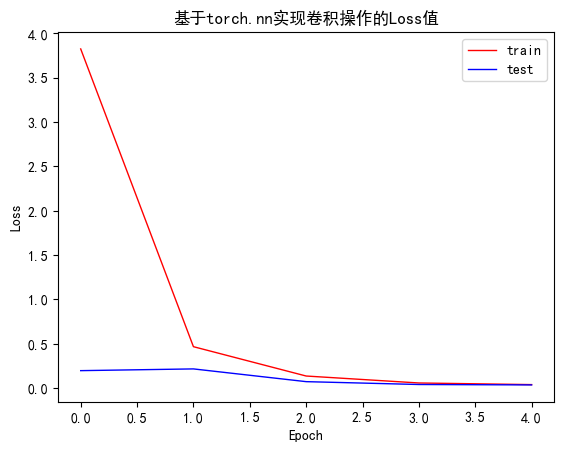

In [10]:
# 初始化模型和超参数参数
epochs = 5
lr = 0.01

model = ConvModule()
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses, test_losses = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses, test_losses, title="基于torch.nn实现卷积操作的Loss值")

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses, 'test_losses': test_losses}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model.pth')

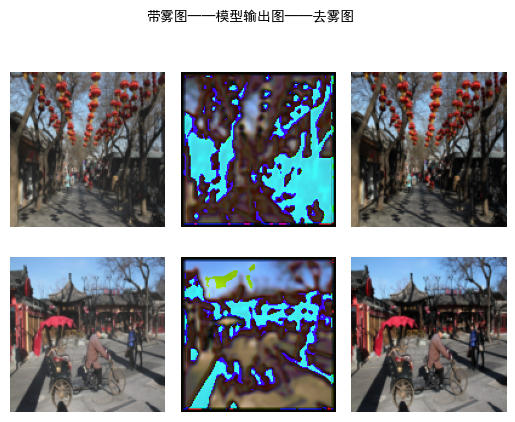

In [11]:
# 加载训练好的模型
model = ConvModule()  # 替换为你的模型类
qualitative_Analysis(model, train_dataset, 'model.pth')

## 3.不同超参数的对比分析

### 3.1 卷积层数对比分析

#### 3.1.1 一层卷积

In [12]:
class ConvModule_1(nn.Module):
    def __init__(self):
        super(ConvModule_1, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=32, out_channels=3, 
                            kernel_size=3, stride=1, padding='same')
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

Epoch: 1/5,	 train_loss: 0.2560,	 test_loss: 0.1025
Epoch: 2/5,	 train_loss: 0.0582,	 test_loss: 0.0773
Epoch: 3/5,	 train_loss: 0.0283,	 test_loss: 0.0332
Epoch: 4/5,	 train_loss: 0.0189,	 test_loss: 0.0141
Epoch: 5/5,	 train_loss: 0.0143,	 test_loss: 0.0125

训练结毕，耗时：37.533565521240234s


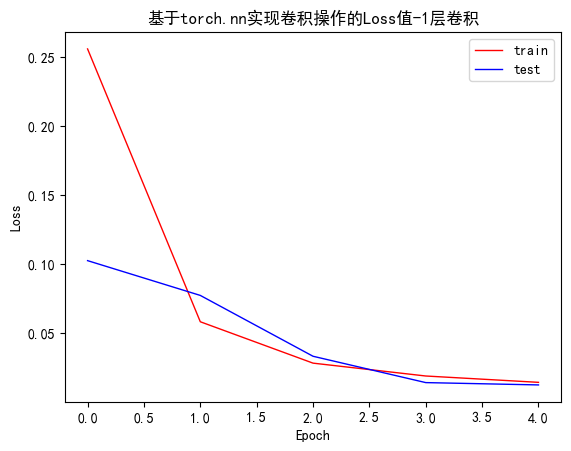

In [13]:
# 初始化模型和超参数参数
epochs = 5
lr = 0.01

model_l1 = ConvModule_1()
optimizer = optim.Adam(model_l1.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses_l1, test_losses_l1 = train(model_l1, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses_l1, test_losses_l1, title="基于torch.nn实现卷积操作的Loss值-1层卷积")

# 保存模型的状态字典和其他信息到文件
model_state = model_l1.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_l1, 'test_losses': test_losses_l1}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_l1.pth')


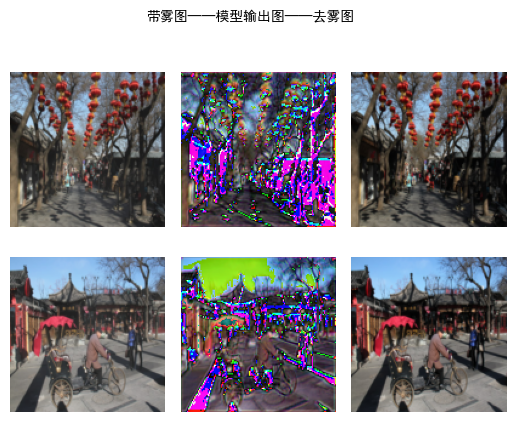

In [14]:
model_l1 = ConvModule_1()
qualitative_Analysis(model_l1, train_dataset, "model_l1.pth")

#### 3.1.2 两层卷积

In [15]:
class ConvModule_2(nn.Module):
    def __init__(self):
        super(ConvModule_2, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=64, out_channels=3, 
                            kernel_size=3, stride=1, padding='same')
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

Epoch: 1/5,	 train_loss: 0.8508,	 test_loss: 0.1965
Epoch: 2/5,	 train_loss: 0.1318,	 test_loss: 0.0293
Epoch: 3/5,	 train_loss: 0.0379,	 test_loss: 0.0201
Epoch: 4/5,	 train_loss: 0.0184,	 test_loss: 0.0135
Epoch: 5/5,	 train_loss: 0.0128,	 test_loss: 0.0102

训练结毕，耗时：57.40393304824829s


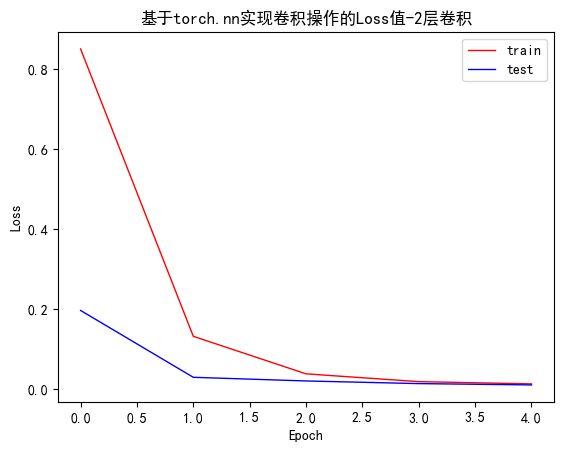

In [16]:
# 初始化模型和超参数参数
epochs = 5
lr = 0.01

model_l2 = ConvModule_2()
optimizer = optim.Adam(model_l2.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses_l2, test_losses_l2 = train(model_l2, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses_l2, test_losses_l2, title="基于torch.nn实现卷积操作的Loss值-2层卷积")

# 保存模型的状态字典和其他信息到文件
model_state = model_l2.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_l2, 'test_losses': test_losses_l2}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_l2.pth')


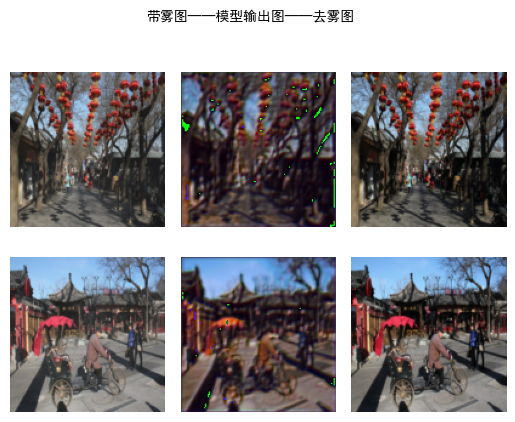

In [17]:
model_l2 = ConvModule_2()
qualitative_Analysis(model_l2, train_dataset, "model_l2.pth")

### 3.1.3 分析实验结果

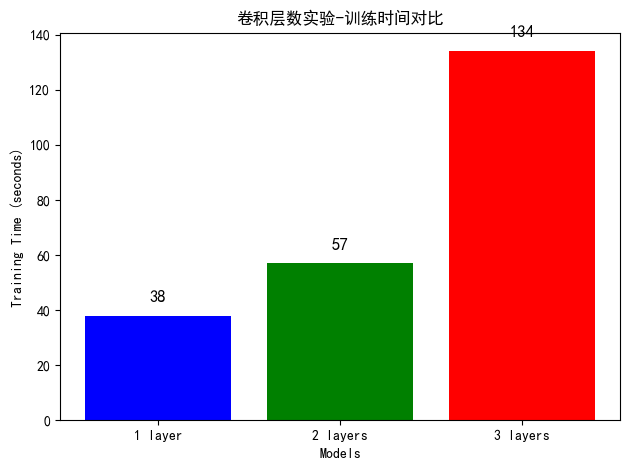

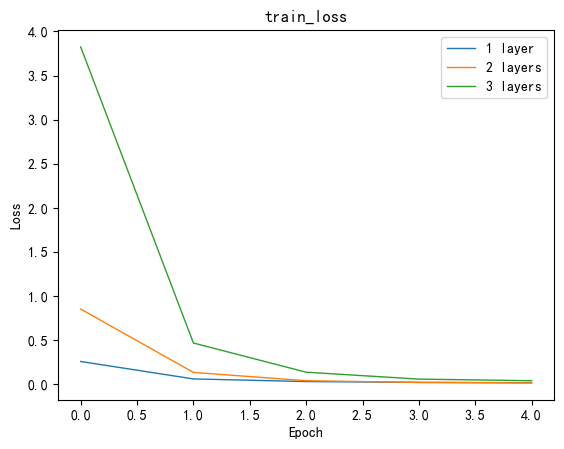

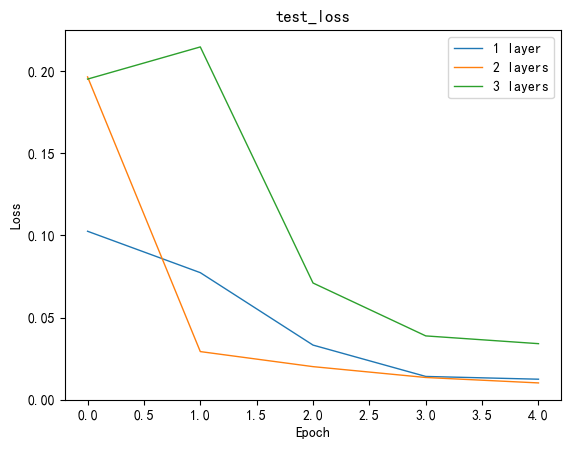

In [29]:
# 训练时间对比
model_labels = ['1 layer', '2 layers', '3 layers']
training_times = [38, 57, 134]
train_time_comparison(training_times, model_labels, "卷积层数实验-训练时间对比")

# 训练损失对比
losses_train = [train_losses_l1, train_losses_l2, train_losses]
losses_test = [test_losses_l1, test_losses_l2, test_losses]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")

### 3.2卷积核大小对比分析

#### 3.2.1 kernel_size=5

In [18]:
class ConvModule_k5(nn.Module):
    def __init__(self):
        super(ConvModule_k5, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=5, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, 
                            kernel_size=5, stride=1, padding='same')
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

Epoch: 1/5,	 train_loss: 34.2498,	 test_loss: 14.7722
Epoch: 2/5,	 train_loss: 3.8371,	 test_loss: 1.1120
Epoch: 3/5,	 train_loss: 0.9758,	 test_loss: 0.1777
Epoch: 4/5,	 train_loss: 0.2262,	 test_loss: 0.1128
Epoch: 5/5,	 train_loss: 0.0884,	 test_loss: 0.0336

训练结毕，耗时：184.50704050064087s


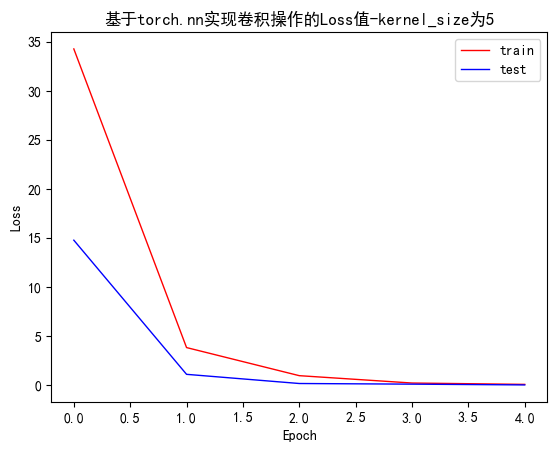

In [19]:
# 初始化模型
model_k5 = ConvModule_k5()
optimizer = optim.Adam(model_k5.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses_k5, test_losses_k5 = train(model_k5, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses_k5, test_losses_k5, title="基于torch.nn实现卷积操作的Loss值-kernel_size为5")

# 保存模型的状态字典和其他信息到文件
model_state = model_k5.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_k5, 'test_losses': test_losses_k5}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_k5.pth')


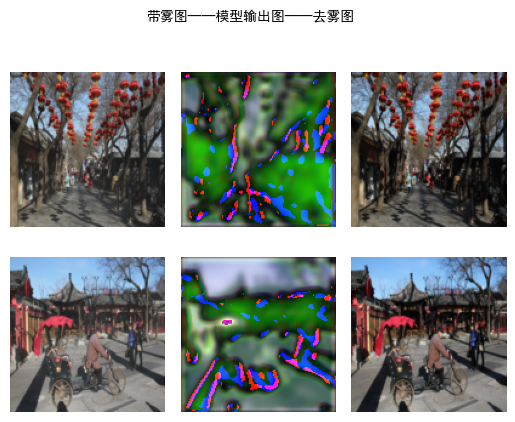

In [20]:
model_k5 = ConvModule_k5()
qualitative_Analysis(model_k5, train_dataset, "model_k5.pth")

#### 3.2.2 kernel_size=8

In [21]:
class ConvModule_k8(nn.Module):
    def __init__(self):
        super(ConvModule_k8, self).__init__()
        # 定义三个卷积层
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, 
                      kernel_size=8, stride=1, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, 
                      kernel_size=8, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, 
                      kernel_size=8, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # 全连接层作输出层，输出图片大小为
        self.fc = nn.Conv2d(in_channels=128, out_channels=3, 
                            kernel_size=8, stride=1, padding='same')
        
    def forward(self, X):
        out = self.conv(X)
        out = self.fc(out)

        return out

d:\FileApp\DevelopApp\Anaconda\envs\Pytorch\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1/5,	 train_loss: 257.5082,	 test_loss: 2197.1741
Epoch: 2/5,	 train_loss: 28.2493,	 test_loss: 8.3915
Epoch: 3/5,	 train_loss: 5.6928,	 test_loss: 2.6034
Epoch: 4/5,	 train_loss: 1.5767,	 test_loss: 1.1590
Epoch: 5/5,	 train_loss: 0.4512,	 test_loss: 0.0881

训练结毕，耗时：390.45726466178894s


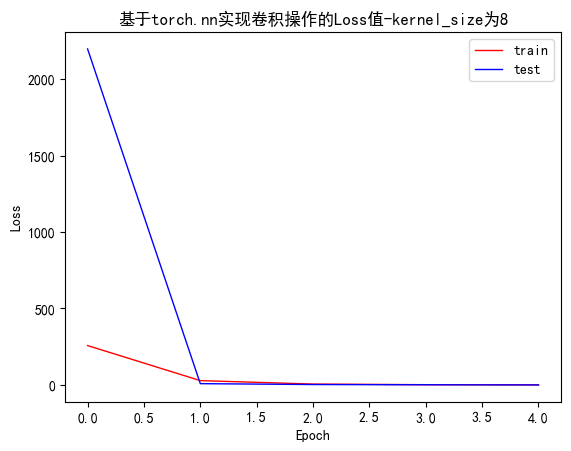

In [22]:
# 初始化模型

model_k8 = ConvModule_k8()
optimizer = optim.Adam(model_k8.parameters(), lr=lr)
criterion = nn.MSELoss()

train_losses_k8, test_losses_k8 = train(model_k8, train_loader, test_loader, criterion, optimizer, epochs, device)

# 绘图
plot_loss(train_losses_k8, test_losses_k8, title="基于torch.nn实现卷积操作的Loss值-kernel_size为8")

# 保存模型的状态字典和其他信息到文件
model_state = model_k8.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses_k8, 'test_losses': test_losses_k8}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_k8.pth')


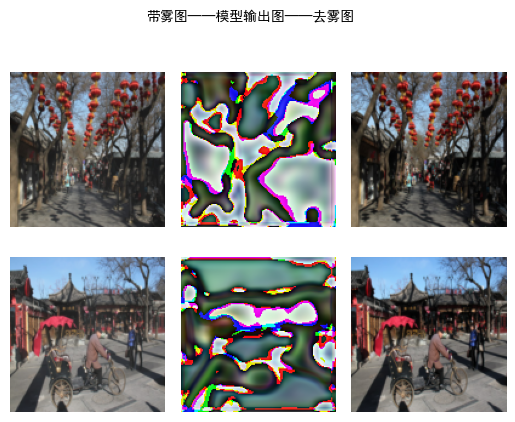

In [23]:
model_k8 = ConvModule_k8()
qualitative_Analysis(model_k8, train_dataset, "model_k8.pth")

### 3.2.3 实验结果分析
可以看出卷积核为8的效果很差，不管是从模型输出的定性分析来看，还是从模型训练测试损失值的定量分析来看，都是比较差的

在做卷积核大小对比实验时，因为卷积层数均为3层，可能存在模型过拟合的情况，经过3.1的卷积层数对比实验可知，去雾效果好的卷积层数应该是两层

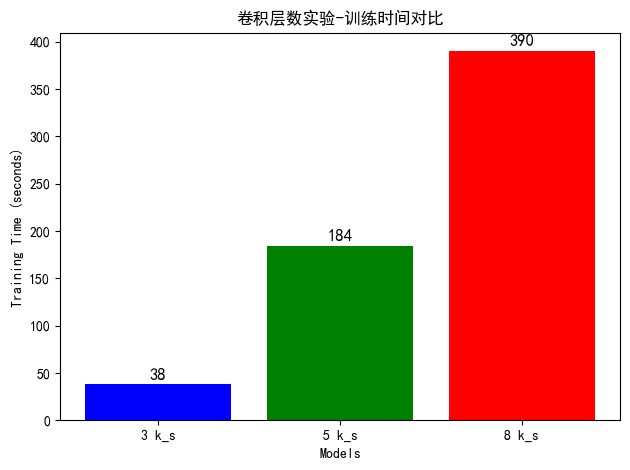

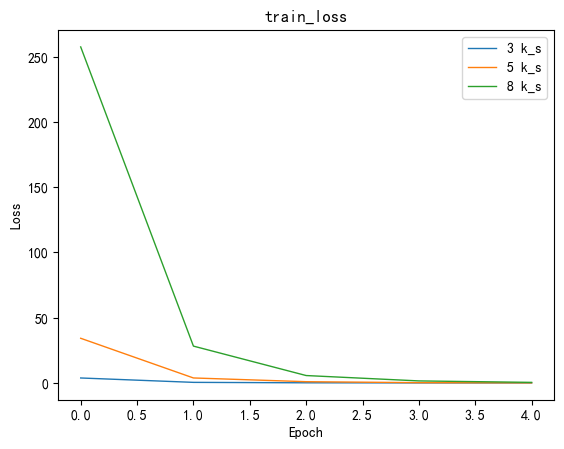

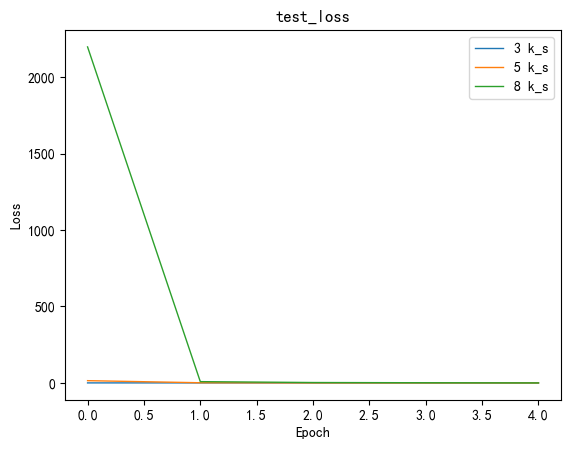

In [30]:
# 训练时间对比
model_labels = ['3 k_s', '5 k_s', '8 k_s']   # k_s表示kernel_size
training_times = [38, 184, 390]
train_time_comparison(training_times, model_labels, "卷积层数实验-训练时间对比")

# 训练损失对比
losses_train = [train_losses, train_losses_k5, train_losses_k8]
losses_test = [test_losses, test_losses_k5, test_losses_k8]

# train loss
loss_comparison(losses_train, model_labels, "train_loss")

# test loss
loss_comparison(losses_test, model_labels, "test_loss")

## 4.使用PyTorch实现AlexNet

### 4.1数据和函数准备（完成分类任务）

In [18]:
# 构建数据集对象
class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        
        # 将传入目录下的文件名转换为列表
        self.classes = os.listdir(data_folder)    # ['bus', 'car', 'truck']
        # 建立类别索引
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}  # {'bus': 0, 'car': 1, 'truck': 2}
        # 数据成员变量，其元素均为元组数据类型，每一个元组构成为（图像路径名，类别索引）
        self.data = self.load_data()
        # 对数据进行打乱
        random.shuffle(self.data)

    def load_data(self):
        data = []
        for cls_name in self.classes:
            # 按类别获取图像文件夹的路径
            cls_folder = os.path.join(self.data_folder, cls_name)
            # 过滤文件后缀并存储同类图像的路径为列表
            images = [os.path.join(cls_folder, img_name) for img_name in os.listdir(cls_folder) if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]
            # 获取该类图像的类别索引
            class_idx = self.class_to_idx[cls_name]
            # 将可迭代的列表添加到data中
            data.extend([(img_path, class_idx) for img_path in images])
        
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_idx = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        return img, class_idx

# Data folder path
data_folder = r"Datasets\CarClassificationDatasets"

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CustomDataset(data_folder, transform=transform)
# 划分数据集
total_samples = len(dataset)
train_samples = int(0.7 * total_samples)
test_samples = total_samples - train_samples

# 划分训练集和测试集
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_samples, test_samples])

# 定义batch_size
batch_size = 32

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("训练集大小：", len(train_dataset))
print("测试集大小：", len(test_dataset))

训练集大小： 949
测试集大小： 408


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义绘图函数

# 绘制训练损失和测试损失的函数
def plot_loss(train_loss, test_loss, title):
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(train_loss))
    plt.plot(x, train_loss, label="train loss", color="red", marker='v', markersize=5, linewidth=2)
    plt.plot(x, test_loss, label="test loss", color="blue", marker='o', markersize=5, linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# 绘制训练损失和测试损失的函数
def plot_acc(train_acc, test_acc, title):
    plt.figure(figsize=(8, 4), dpi=100)
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label="train acc", color="red", marker='v', markersize=5, linewidth=2)
    plt.plot(x, test_acc, label="test acc", color="blue", marker='o', markersize=5, linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.show()

# 训练函数
def train_model(model, data_loader, criterion, optimizer, device):
    model.train()
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0     # 记录分类正确数
    sample_num = 0  # 记录样本总数

    # 遍历每个batch进行训练
    for batch_idx, (data, target) in enumerate(data_loader):
        # 将图片放入指定的device中
        data, target = data.to(device).float(), target.to(device).long()

        # 梯度清零
        optimizer.zero_grad()
        # 前向传播
        output = model(data)
        # 计算损失
        loss = criterion(output, target)
        # 反向传播
        loss.backward()
        # 更新梯度
        optimizer.step()
        
        # 累加loss
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        # 统计正确数
        correct += (prediction == target).sum().item()
        # 累加当前样本数量
        sample_num += len(prediction)

    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

# 测试函数
def test_model(model, data_loader, criterion, device):
    model.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device).float(), target.to(device).long()
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()

            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)

    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

# 模型训练过程函数
def train(model, train_loader, test_loader, criterion, optimizer, epochs, device):
    # 训练模型并验证
    train_losses = []
    train_acc_list = []
    test_losses = []
    test_acc_list = []
    start = time.time()

    # 进行训练
    for epoch in range(epochs):
        # 在训练集上训练
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device=device)

        # 在测试集上训练
        test_loss, test_acc = test_model(model, test_loader, criterion, device=device)

        train_losses.append(train_loss)
        train_acc_list.append(train_acc)
        test_losses.append(test_loss)
        test_acc_list.append(test_acc)

        print(f'Epoch: {epoch + 1}/{epochs},\t train_loss: {train_loss:.4f},\t train_acc: {train_acc:.4f},\t test_loss: {test_loss:.4f},\t test_acc: {test_acc:.4f}')

    end = time.time()
    print(f'\n训练结毕，耗时：{end - start}s')
    return train_losses, train_acc_list, test_losses, test_acc_list


### 4.2 模型复现

In [21]:
# 定义AlexNet模型
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding='same'),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6), # 将图片大小池化为1*1
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=384, out_features=4096),
            # 加入dropout
            nn.Dropout(0.3),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=4096),
            # 加入dropout
            nn.Dropout(0.3),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=3),
        )
        
    
    def forward(self, X):
        # 输入x维度: [batch_size, channel=3, H=227, W=227]
        output = self.conv(X)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output


In [22]:
# 模型输出测试
model = AlexNet()
output = model(train_dataset[1][0].unsqueeze(0)).squeeze()
output.shape

torch.Size([3])

### 4.3 模型训练

In [23]:
# 初始化模型和超参数
epochs = 10
lr = 0.001

criterion = nn.CrossEntropyLoss()
model = AlexNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, train_acc_list, test_losses, test_acc_list = train(model, train_loader, test_loader, criterion, optimizer, epochs, device)

# 保存模型的状态字典和其他信息到文件
model_state = model.state_dict()
other_info = {'epoch': epochs, 'train_losses': train_losses, 'train_acc_list':train_acc_list, 'test_losses': test_losses, 'test_acc_list':test_acc_list}
torch.save({'model_state': model_state, 'other_info': other_info}, 'model_AlexNet.pth')

Epoch: 1/10,	 train_loss: 1.0190,	 train_acc: 0.5448,	 test_loss: 0.9515,	 test_acc: 0.5858
Epoch: 2/10,	 train_loss: 0.8779,	 train_acc: 0.6122,	 test_loss: 0.6100,	 test_acc: 0.7794
Epoch: 3/10,	 train_loss: 0.5318,	 train_acc: 0.7956,	 test_loss: 0.5182,	 test_acc: 0.7941
Epoch: 4/10,	 train_loss: 0.3919,	 train_acc: 0.8440,	 test_loss: 0.3469,	 test_acc: 0.8578
Epoch: 5/10,	 train_loss: 0.3232,	 train_acc: 0.8778,	 test_loss: 0.4603,	 test_acc: 0.8186
Epoch: 6/10,	 train_loss: 0.3178,	 train_acc: 0.8820,	 test_loss: 0.3577,	 test_acc: 0.8480
Epoch: 7/10,	 train_loss: 0.2517,	 train_acc: 0.9020,	 test_loss: 0.3630,	 test_acc: 0.8652
Epoch: 8/10,	 train_loss: 0.2664,	 train_acc: 0.8936,	 test_loss: 0.3910,	 test_acc: 0.8186
Epoch: 9/10,	 train_loss: 0.2157,	 train_acc: 0.9125,	 test_loss: 0.3078,	 test_acc: 0.8725
Epoch: 10/10,	 train_loss: 0.2223,	 train_acc: 0.9136,	 test_loss: 0.2830,	 test_acc: 0.8873

训练结毕，耗时：113.2115786075592s


### 4.4 实验结果分析
可以看出模型训练的相对来说比较稳定，在第三个epoch处测试损失有些上升，过后模型精度又开始上升，说明此处并不是过拟合，模型仍在训练中，最终模型的分类准确率达到了88.73%，训练时间为113s，卷积层数较少，训练速度较快

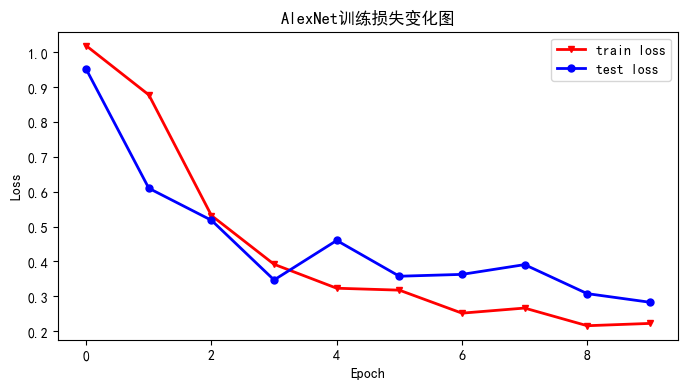

In [24]:
# 模型损失变化图
plot_loss(train_losses, test_losses, title="AlexNet训练损失变化图")

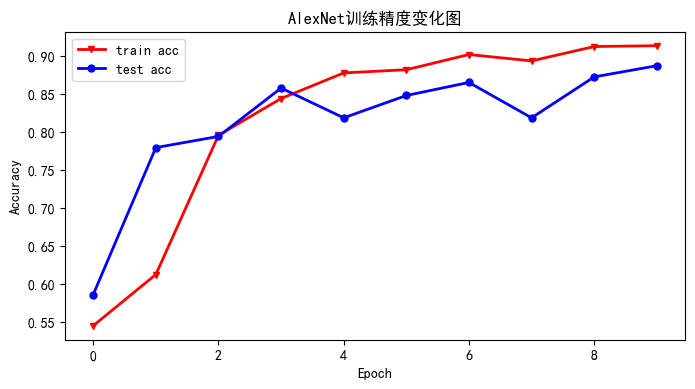

In [25]:
# 模型训练精度变化图
plot_acc(train_acc_list, test_acc_list, title='AlexNet训练精度变化图')

第1张图片，原始类别为：['bus'], 预测类别为：['bus']
第2张图片，原始类别为：['car'], 预测类别为：['bus']
第3张图片，原始类别为：['car'], 预测类别为：['car']
第4张图片，原始类别为：['car'], 预测类别为：['car']
第5张图片，原始类别为：['bus'], 预测类别为：['truck']


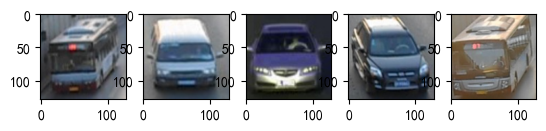

In [26]:
# 模型定性分析
classes = {'bus': 0, 'car': 1, 'truck': 2}
# 定义一个根据值索引键的函数
def get_keys_by_value(dictionary, target_value):
    keys_with_target_value = []
    for key, value in dictionary.items():
        if value == target_value:
            keys_with_target_value.append(key)
    return keys_with_target_value

model = AlexNet()
checkpoint = torch.load('model_AlexNet.pth')  # 替换为你的模型检查点文件路径
model.load_state_dict(checkpoint['model_state'])
model.eval()  # 设置模型为评估模式

# 抽样显示训练集中图片
fig, axes = plt.subplots(1, 5)
for i in range(5):
    # 使用模型进行预测
    rand_num = np.random.randint(1, 101)
    with torch.no_grad():
        # 随机选取图片输入
        output = model(test_dataset[i+rand_num][0].unsqueeze(0)).squeeze()
        prediction = torch.argmax(output)
        label = get_keys_by_value(classes, test_dataset[i+rand_num][1])
        predict = get_keys_by_value(classes, prediction)
        print(f'第{i+1}张图片，原始类别为：{label}, 预测类别为：{predict}')
        
    axes[i].imshow(transforms.ToPILImage()(test_dataset[i+rand_num][0]))

plt.show()